# TP1 - Intro a EPH

In [4]:
# Importamos las librerías necesarios para responder el TP
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Parte I - Inciso (a)
## Filtrado por región (Gran Buenos Aires) y unión de las bases 2005 y 2025

In [5]:
# Cargamos las bases de datos
df_2005 = pd.read_stata("data/usu_individual_T105.dta", convert_categoricals=False)
df_2025 = pd.read_excel("data/usu_individual_T125.xlsx")

In [6]:
# Verificamos dimensiones iniciales
print("Dimensiones base 2005:", df_2005.shape)
print("Dimensiones base 2025:", df_2025.shape)

Dimensiones base 2005: (47030, 176)
Dimensiones base 2025: (45425, 235)


In [7]:
#Limpiamos la base de 2005 por que tiene valores que no se detectan como númericos y los nombres de sus columnas están en minúsculas

#Convertimos los nombres de las variables en mayúsculas
df_2005.columns = df_2005.columns.str.upper()

# Detectamos columnas numéricas
cols_num = df_2005.select_dtypes(include=["float", "int"]).columns

# Convertir solo las columnas cuyos valores sean enteros (sin parte decimal)
for col in cols_num:
    # Si todos los valores son NaN o números enteros, convertir
    if df_2005[col].dropna().apply(float.is_integer).all():
        df_2005[col] = df_2005[col].astype("Int64")  # maneja NAs correctamente

In [8]:
# Verificar codificación de la variable REGION
print("Valores únicos en REGION (2005):", df_2005["REGION"].unique())
print("Valores únicos en REGION (2025):", df_2025["REGION"].unique())

Valores únicos en REGION (2005): <IntegerArray>
[1, 40, 41, 42, 43, 44]
Length: 6, dtype: Int64
Valores únicos en REGION (2025): [43 41 42 40 44  1]


In [9]:
# Distribución de observaciones por región en 2005
print("Cantidad de observaciones por región (2005):")
print(df_2005["REGION"].value_counts())

# Distribución de observaciones por región en 2025
print("\nCantidad de observaciones por región (2025):")
print(df_2025["REGION"].value_counts())

Cantidad de observaciones por región (2005):
REGION
43    14651
1      9484
40     9348
41     5453
42     4865
44     3229
Name: count, dtype: Int64

Cantidad de observaciones por región (2025):
REGION
43    13803
40     9742
1      7181
44     5359
41     4746
42     4594
Name: count, dtype: int64


In [10]:
# Filtramos por Gran Buenos Aires
df_2005 = df_2005[df_2005["REGION"] == 1].copy()
df_2025 = df_2025[df_2025["REGION"] == 1].copy()

In [11]:
# Verificamos dimensiones iniciales
print("Dimensiones base 2005:", df_2005.shape)
print("Dimensiones base 2025:", df_2025.shape)

Dimensiones base 2005: (9484, 176)
Dimensiones base 2025: (7181, 235)


In [49]:
print("Dimensiones base 2005:", df_2005.shape)
print("Dimensiones base 2025:", df_2025.shape)

Dimensiones base 2005: (9484, 177)
Dimensiones base 2025: (7181, 236)


In [13]:
# Unir las bases una debajo de otra (filas)
df_unido = pd.concat([df_2005, df_2025], axis=0, ignore_index=True)

In [14]:
# Confirmamos resultado
print("Dimensiones base unificada:", df_unido.shape)
print("Años disponibles:", df_unido['AÑO'].unique())

Dimensiones base unificada: (16665, 244)
Años disponibles: [2005 2025]


# Parte I - Inciso (b)
## Selección de variables y análisis de valores faltantes

In [15]:
variables_interes = [
    "CH04", "CH06", "CH07", "CH08", "NIVEL_ED",
    "ESTADO", "CAT_INAC", "IPCF", "CAT_OCUP", "PP07H",
    "P21", "CH15", "PP10A", "PP04G", "PP3E_TOT"
]

# Verificar que todas existan en la base
vars_disponibles = [v for v in variables_interes if v in df_unido.columns]
print("Variables encontradas en la base:", vars_disponibles)

Variables encontradas en la base: ['CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC', 'IPCF', 'CAT_OCUP', 'PP07H', 'P21', 'CH15', 'PP10A', 'PP04G', 'PP3E_TOT']


In [16]:
# Creamos un nuevo DataFrame con solo las variables elegidas + el año
df_vars = df_unido[vars_disponibles + ["AÑO"]].copy()

In [17]:
# Asegurarnos de que todas las variables numéricas estén en el formato correcto
# Si alguna columna quedó como texto (object), intentamos convertirla a numérica
# Los valores no convertibles (por ejemplo "No sabe") se transforman en NaN

for col in df_vars.columns:
    if col != "AÑO":  # no queremos modificar la columna de año
        df_vars[col] = pd.to_numeric(df_vars[col], errors="coerce")

In [18]:
# Separamos las bases por año para calcular los valores faltantes de cada una

df_2005_sel = df_vars[df_vars["AÑO"] == 2005]
df_2025_sel = df_vars[df_vars["AÑO"] == 2025]

# Calculamos la proporción de valores faltantes (NaN) en cada variable
faltantes_2005 = df_2005_sel.isna().mean().to_frame(name="2005")
faltantes_2025 = df_2025_sel.isna().mean().to_frame(name="2025")

# Unimos ambas tablas de faltantes
faltantes = faltantes_2005.join(faltantes_2025)

# Eliminamos la fila de "AÑO" porque no nos interesa analizar esa columna
faltantes = faltantes.drop(index="AÑO")


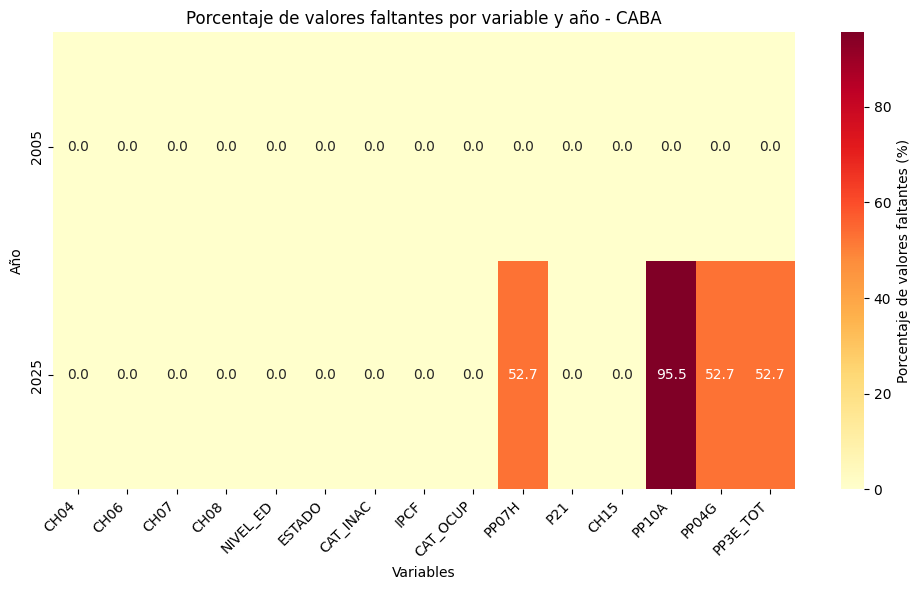

In [19]:
# Visualizar los valores faltantes en un heatmap
# Convertimos proporciones a porcentajes multiplicando por 100
faltantes = faltantes * 100

# Configuramos el gráfico de calor (heatmap)
plt.figure(figsize=(10,6))  # tamaño del gráfico
sns.heatmap(
    faltantes.T,                 # trasponemos para que los años queden en el eje Y
    cmap="YlOrRd",               # paleta de colores (amarillo a rojo)
    annot=True,                  # mostrar los valores dentro de cada celda
    fmt=".1f",                   # formato de los números (una cifra decimal)
    cbar_kws={'label': 'Porcentaje de valores faltantes (%)'}  # etiqueta de la barra de color
)

# Títulos y etiquetas
plt.title("Porcentaje de valores faltantes por variable y año - CABA")
plt.xlabel("Variables")
plt.ylabel("Año")
plt.xticks(rotation=45, ha="right")  # rotamos los nombres de variables para mayor legibilidad
plt.tight_layout()
plt.show()


# Parte I - Inciso (c)
## Selección de variables y análisis de valores faltantes

In [20]:
# Hay variables que en ambos años, en vez de tener valor faltante, tiene 0
#Esto es un error, debido a que en esas variables no hay ninguna categoría que se defina como 0

# Variables con valores 0 que deben tratarse como faltantes en 2005
vars_0_2005 = ["CAT_INAC", "CAT_OCUP", "PP07H", "CH15", "PP10A", "PP04G", "PP3E_TOT"]

# Variables con valores 0 que deben tratarse como faltantes en 2025
vars_0_2025 = ["CAT_INAC", "CAT_OCUP", "PP07H", "PP04G", "PP10A", "ESTADO"]

# Creamos dos subconjuntos según el año
df_2005_corr = df_unido[df_unido["AÑO"] == 2005].copy()
df_2025_corr = df_unido[df_unido["AÑO"] == 2025].copy()

# Reemplazamos los valores 0 por NaN en cada subconjunto

# Para 2005
for col in vars_0_2005:
    if col in df_2005_corr.columns:
        df_2005_corr.loc[df_2005_corr[col] == 0, col] = np.nan

# Para 2025
for col in vars_0_2025:
    if col in df_2025_corr.columns:
        df_2025_corr.loc[df_2025_corr[col] == 0, col] = np.nan

# Volvemos a unir las bases corregidas

df_unido_corr = pd.concat([df_2005_corr, df_2025_corr], ignore_index=True)

# Verificamos que el reemplazo se haya hecho correctamente

#Contamos cuántos ceros quedan en las variables corregidas
def contar_ceros(df, columnas):
    resumen = {}
    for col in columnas:
        if col in df.columns:
            resumen[col] = (df[col] == 0).sum()
    return resumen

# Contar ceros por año después de la corrección
print("Ceros restantes en 2005:", contar_ceros(df_2005_corr, vars_0_2005))
print("Ceros restantes en 2025:", contar_ceros(df_2025_corr, vars_0_2025))

# Confirmamos que las columnas fueron corregidas correctamente
print("Tamaño base final:", df_unido_corr.shape)


Ceros restantes en 2005: {'CAT_INAC': np.int64(0), 'CAT_OCUP': np.int64(0), 'PP07H': np.int64(0), 'CH15': np.int64(0), 'PP10A': np.int64(0), 'PP04G': np.int64(0), 'PP3E_TOT': np.int64(0)}
Ceros restantes en 2025: {'CAT_INAC': np.int64(0), 'CAT_OCUP': np.int64(0), 'PP07H': np.int64(0), 'PP04G': np.int64(0), 'PP10A': np.int64(0), 'ESTADO': np.int64(0)}
Tamaño base final: (16665, 244)


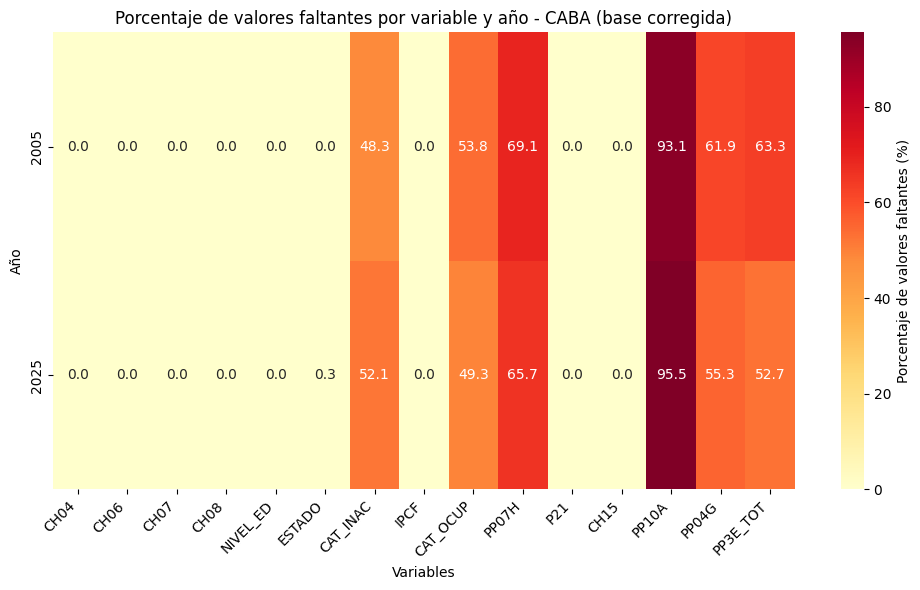

In [21]:
# ACTUALIZAMOS EL HEATMAP DE VALORES FALTANTES (tras corrección de ceros)

# Seleccionamos otra vez las mismas 15 variables de interés
variables_interes = [
    "CH04", "CH06", "CH07", "CH08", "NIVEL_ED",
    "ESTADO", "CAT_INAC", "IPCF", "CAT_OCUP", "PP07H",
    "P21", "CH15", "PP10A", "PP04G", "PP3E_TOT"
]

# Creamos un nuevo DataFrame con las variables corregidas + el año
df_vars_corr = df_unido_corr[variables_interes + ["AÑO"]].copy()

# Aseguramos que todas las variables sean numéricas
# (si alguna quedó como texto, la convertimos)
for col in df_vars_corr.columns:
    if col != "AÑO":
        df_vars_corr[col] = pd.to_numeric(df_vars_corr[col], errors="coerce")

# Separamos las bases por año
df_2005_corr = df_vars_corr[df_vars_corr["AÑO"] == 2005]
df_2025_corr = df_vars_corr[df_vars_corr["AÑO"] == 2025]

# Calculamos la proporción de valores faltantes
faltantes_2005 = df_2005_corr.isna().mean().to_frame(name="2005")
faltantes_2025 = df_2025_corr.isna().mean().to_frame(name="2025")

# Unimos ambas tablas
faltantes_corr = faltantes_2005.join(faltantes_2025)

# Quitamos la fila de AÑO
faltantes_corr = faltantes_corr.drop(index="AÑO")

# Convertimos proporciones a porcentaje
faltantes_corr = faltantes_corr * 100

# Graficamos el heatmap actualizado
plt.figure(figsize=(10,6))
sns.heatmap(
    faltantes_corr.T,
    cmap="YlOrRd",
    annot=True,
    fmt=".1f",
    cbar_kws={'label': 'Porcentaje de valores faltantes (%)'}
)
plt.title("Porcentaje de valores faltantes por variable y año - CABA (base corregida)")
plt.xlabel("Variables")
plt.ylabel("Año")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Identificamos automáticamente las variables con más faltantes por año
max_2005 = faltantes_corr["2005"].idxmax()
max_2025 = faltantes_corr["2025"].idxmax()

In [22]:
# Creamos una copia de la base corregida para trabajar con seguridad
df_limpio = df_unido_corr.copy()

# Reemplazamos valores negativos o cero en variables de ingreso por NaN
# Según la documentación de la EPH, las variables IPCF, P21 y PP3E_TOT son monetarias
# y no pueden tener valores negativos o iguales a cero.
for col in ["IPCF", "P21", "PP3E_TOT"]:
    if col in df_limpio.columns:
        df_limpio.loc[df_limpio[col] <= 0, col] = np.nan

# Eliminamos valores extremos o sin sentido (por ejemplo, edades mayores a 100 años)
if "CH06" in df_limpio.columns:
    df_limpio.loc[df_limpio["CH06"] > 100, "CH06"] = np.nan

# Confirmamos que las correcciones se aplicaron correctamente
print("Cantidad de valores negativos o cero por variable (después de la limpieza):")
for col in ["IPCF", "P21", "PP3E_TOT"]:
    if col in df_limpio.columns:
        negativos = (df_limpio[col] <= 0).sum(skipna=True)
        print(f"{col}: {negativos}")

# Mostramos un resumen de las variables numéricas después de la limpieza
print("\nResumen estadístico de las variables limpias:")
print(df_limpio[variables_interes].describe().T[["count", "mean", "min", "max"]])

Cantidad de valores negativos o cero por variable (después de la limpieza):
IPCF: 0
P21: 0
PP3E_TOT: 0

Resumen estadístico de las variables limpias:
            count           mean  min         max
CH04      16665.0       1.523372  1.0         2.0
CH06      16665.0      35.643024 -1.0       100.0
CH07      16665.0       3.460726  1.0         9.0
CH08      16665.0       2.326433  1.0        13.0
NIVEL_ED  16665.0       3.609661  1.0         7.0
ESTADO    16644.0       2.193523  0.0         4.0
CAT_INAC   8344.0       3.302133  1.0         7.0
IPCF      13680.0  195128.987792  2.5  10000000.0
CAT_OCUP   8024.0       2.725823  1.0         9.0
PP07H      5388.0       1.402004  1.0         2.0
P21        6061.0  350270.194852  4.0  20000000.0
CH15      16665.0       1.543354  1.0         9.0
PP10A       978.0       3.078732  1.0         9.0
PP04G      6819.0         6.1072  1.0        99.0
PP3E_TOT   6557.0      49.523563  1.0       999.0


# Parte I - Inciso (d)
## Selección de variables y análisis de valores faltantes

In [23]:
import pandas as pd
import numpy as np

In [24]:
df_hogar_2005 = pd.read_stata("data/usu_hogar_T105.dta", convert_categoricals=False)
df_hogar_2025 = pd.read_excel("data/usu_hogar_T125.xlsx")

In [25]:
# Convertimos nombres de columnas de 2005 a mayúsculas
df_hogar_2005.columns = df_hogar_2005.columns.str.upper()

In [26]:
# Convertimos columnas numéricas con decimales innecesarios a enteros cuando sea posible
cols_num = df_hogar_2005.select_dtypes(include=["float", "int"]).columns
for col in cols_num:
    if df_hogar_2005[col].dropna().apply(float.is_integer).all():
        df_hogar_2005[col] = df_hogar_2005[col].astype("Int64")

In [27]:
# Filtramos por la región Gran Buenos Aires (REGION = 1)
df_hogar_2005 = df_hogar_2005[df_hogar_2005["REGION"] == 1].copy()
df_hogar_2025 = df_hogar_2025[df_hogar_2025["REGION"] == 1].copy()

In [28]:
# Verificamos dimensiones iniciales
print("Dimensiones base 2005:", df_hogar_2005.shape)
print("Dimensiones base 2025:", df_hogar_2025.shape)

Dimensiones base 2005: (2943, 88)
Dimensiones base 2025: (2609, 98)


In [29]:
# Agregamos la columna de año
df_hogar_2005["AÑO"] = 2005
df_hogar_2025["AÑO"] = 2025

In [30]:
# Seleccionamos las variables solicitadas
variables_hogar = ["CODUSU", "NRO_HOGAR", "IV1", "IV2", "IV6", "IV8", "II8", "AÑO"]
df_hogar_2005 = df_hogar_2005[variables_hogar]
df_hogar_2025 = df_hogar_2025[variables_hogar]

In [31]:
# Unimos ambas bases de hogares una debajo de la otra
df_hogar = pd.concat([df_hogar_2005, df_hogar_2025], ignore_index=True)

In [32]:
# Revisamos estructura final
print("Dimensiones base de hogares unificada:", df_hogar.shape)
print("Años disponibles:", df_hogar['AÑO'].unique())

Dimensiones base de hogares unificada: (5552, 8)
Años disponibles: [2005 2025]


In [33]:
# ==========================================================
# Realizamos las uniones con la base individual
# ==========================================================
# Usamos las claves CODUSU y NRO_HOGAR como llaves de unión
llaves = ["CODUSU", "NRO_HOGAR"]


In [34]:
# Creamos un diccionario para guardar los resultados
resultados_union = {}

In [35]:
# Unión por intersección (inner)
union_inner = pd.merge(df_limpio, df_hogar, on=llaves, how="inner")
resultados_union["intersección"] = [
    union_inner.shape[0], union_inner.shape[1], union_inner.isna().sum().sum()
]

In [36]:
# Verificamos dimensiones iniciales
print("Dimensiones:", union_inner.shape)

Dimensiones: (16665, 250)


In [37]:
# Unión por izquierda (left)
union_left = pd.merge(df_limpio, df_hogar, on=llaves, how="left")
resultados_union["izquierda"] = [
    union_left.shape[0], union_left.shape[1], union_left.isna().sum().sum()
]

In [38]:
# Unión por derecha (right)
union_right = pd.merge(df_limpio, df_hogar, on=llaves, how="right")
resultados_union["derecha"] = [
    union_right.shape[0], union_right.shape[1], union_right.isna().sum().sum()
]

In [39]:
# Unión conjunta (outer)
union_outer = pd.merge(df_limpio, df_hogar, on=llaves, how="outer")
resultados_union["conjunta"] = [
    union_outer.shape[0], union_outer.shape[1], union_outer.isna().sum().sum()
]

In [40]:
# Creamos un DataFrame resumen con los resultados
tabla_union = pd.DataFrame.from_dict(
    resultados_union, orient="index", columns=["Nro. de filas", "Nro. de columnas", "Total de NAs"]
)

In [41]:
# Mostramos la tabla resumen
print("\nTabla 1. Reporte de unión de base Hogares e Individuos de la EPH")
print(tabla_union)


Tabla 1. Reporte de unión de base Hogares e Individuos de la EPH
              Nro. de filas  Nro. de columnas  Total de NAs
intersección          16665               250       1460398
izquierda             16665               250       1460398
derecha               16665               250       1460398
conjunta              16665               250       1460398


# Parte II - Inciso (3)
## Selección de variables y análisis de valores faltantes

Distribución de personas por sexo y año:
AÑO   CH04
2005  2       4980
      1       4504
2025  2       3742
      1       3439
Name: count, dtype: Int64


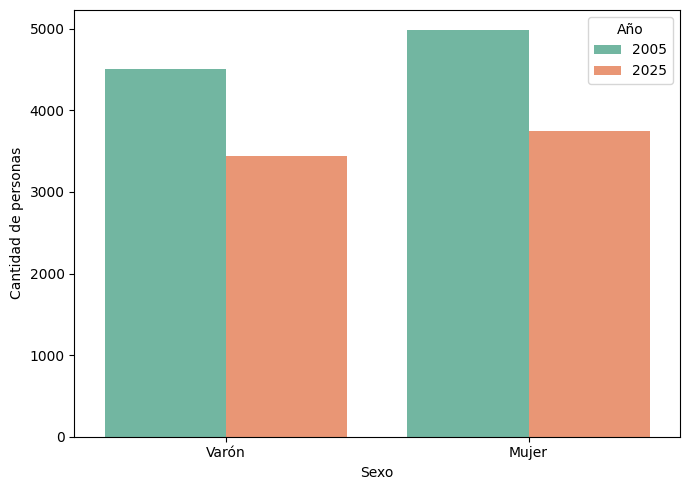

In [42]:
# PARTE II - Primer Análisis Exploratorio
# Punto 3: Composición por sexo en Gran Buenos Aires - 2005 y 2025

import seaborn as sns
import matplotlib.pyplot as plt

# Aseguramos que las figuras se generen dentro del notebook
%matplotlib inline

# Mostramos la cantidad de casos por sexo y año
print("Distribución de personas por sexo y año:")
print(df_limpio.groupby("AÑO")["CH04"].value_counts())

# Creamos una figura explícita
fig, ax = plt.subplots(figsize=(7,5))

# Graficamos directamente sobre el objeto ax
sns.countplot(data=df_limpio, x="CH04", hue="AÑO", palette="Set2", ax=ax)

# Etiquetas y formato
ax.set_xticks([0,1])
ax.set_xticklabels(["Varón", "Mujer"])
ax.set_title("")
ax.set_xlabel("Sexo")
ax.set_ylabel("Cantidad de personas")
ax.legend(title="Año")

plt.tight_layout()

# Guardamos correctamente la figura (antes de mostrar)
fig.savefig("Composicion_Sexo_GBA.png", dpi=300, bbox_inches="tight")

# Mostramos el gráfico
plt.show()

# Parte II - Inciso (4)
## Matriz de correlación para 2005 y 2025

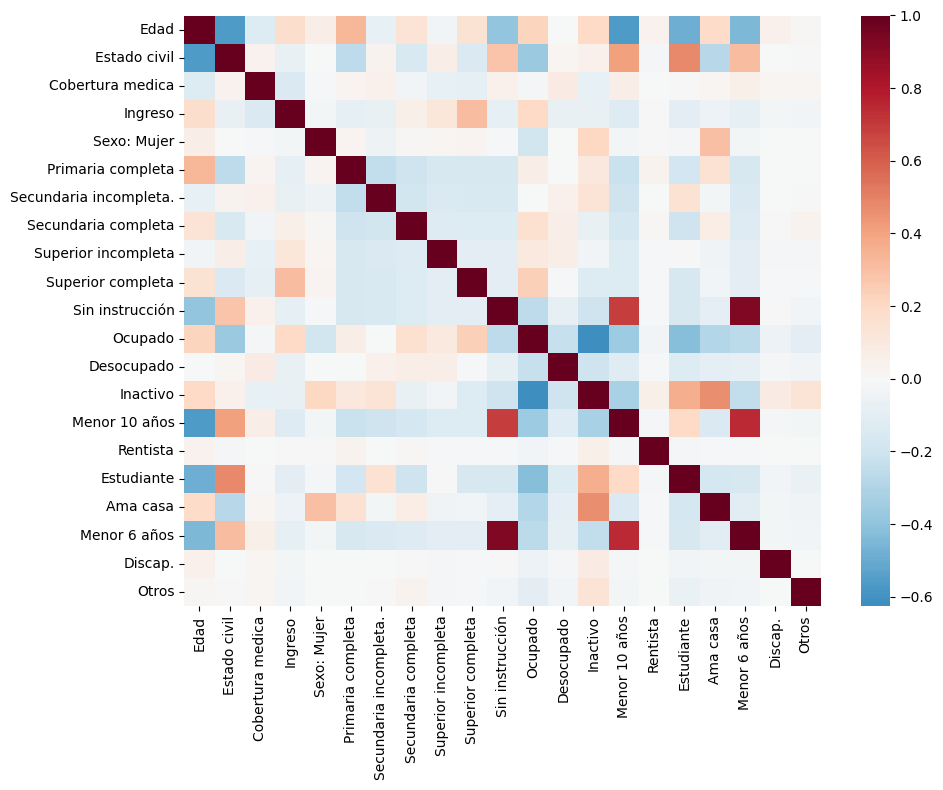

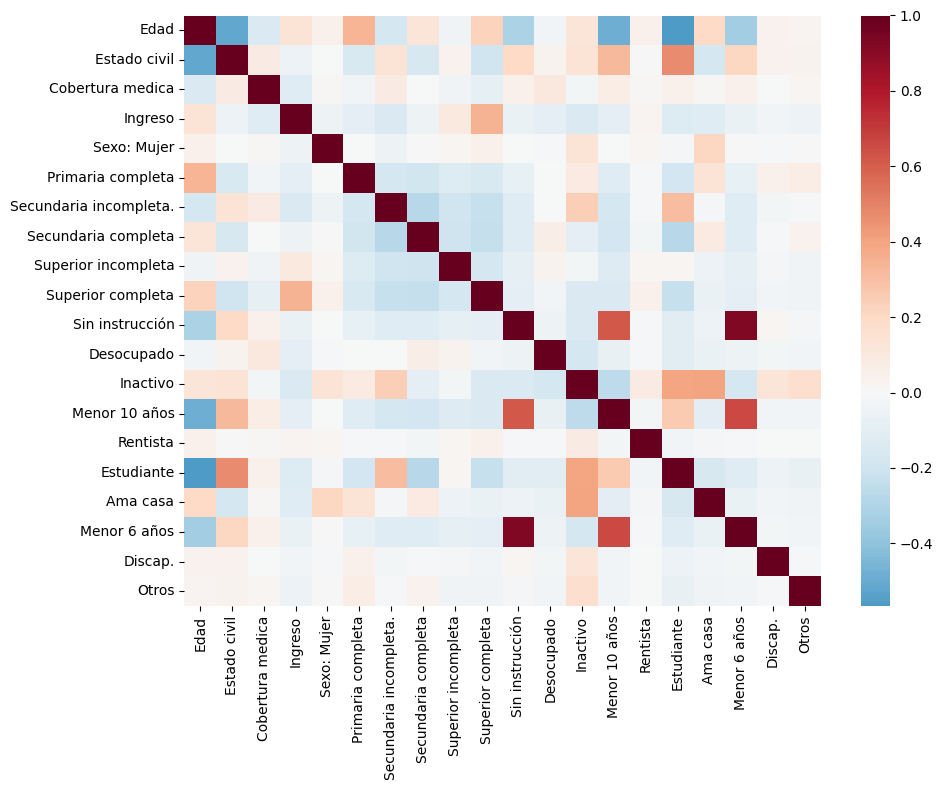

In [43]:
# Variables que analizamos
vars_corr = ["CH04", "CH06", "CH07", "CH08", "NIVEL_ED", "ESTADO", "CAT_INAC", "IPCF"]

# Diccionarios de etiquetas (para mostrar en el gráfico)
labels_map = {
    "CH04_2": "Sexo: Mujer",
    "CH06": "Edad",
    "CH07": "Estado civil",
    "CH08": "Cobertura medica",
    "IPCF": "Ingreso",
    "NIVEL_ED_2": "Primaria completa",
    "NIVEL_ED_3": "Secundaria incompleta.",
    "NIVEL_ED_4": "Secundaria completa",
    "NIVEL_ED_5": "Superior incompleta",
    "NIVEL_ED_6": "Superior completa",
    "NIVEL_ED_7": "Sin instrucción",
    "ESTADO_1": "Ocupado",
    "ESTADO_2": "Desocupado",
    "ESTADO_3": "Inactivo",
    "ESTADO_4": "Menor 10 años",
    "CAT_INAC_1": "Jubilado",
    "CAT_INAC_2": "Rentista",
    "CAT_INAC_3": "Estudiante",
    "CAT_INAC_4": "Ama casa",
    "CAT_INAC_5": "Menor 6 años",
    "CAT_INAC_6": "Discap.",
    "CAT_INAC_7": "Otros"
}

# Función para crear, graficar y exportar la matriz de correlación
def matriz_correlacion(df, año):
    # Filtramos por año
    df_año = df[df["AÑO"] == año][vars_corr].copy()
    
    # Creamos variables dummies (sin alterar los tipos)
    df_dummies = pd.get_dummies(df_año, columns=["CH04", "NIVEL_ED", "ESTADO", "CAT_INAC"], drop_first=True)
    
    # Calculamos la matriz de correlación
    corr = df_dummies.corr(method="pearson")
    
    # Renombramos columnas y filas solo para visualización
    corr.rename(columns=labels_map, index=labels_map, inplace=True)
    
    # Graficamos y guardamos
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(corr, cmap="RdBu_r", center=0, annot=False, ax=ax)
    ax.set_title(f"")
    plt.tight_layout()
    
    # Guardamos la figura antes de mostrar
    fig.savefig(f"Matriz_Correlacion_GBA_{año}.png", dpi=300, bbox_inches="tight")
    
    # Mostramos el gráfico
    plt.show()
    
    return corr

# Generamos y exportamos las matrices para ambos años
corr_2005 = matriz_correlacion(df_limpio, 2005)
corr_2025 = matriz_correlacion(df_limpio, 2025)


# Parte III - Inciso (5)
##  Conociendo a los pobres y no pobres

In [45]:
#Creamos una copia del dataset original
df_copia = df_limpio.copy()

# Contar cuántas personas NO respondieron su condición de actividad (ESTADO)
#    Suponemos que no respondieron si ESTADO está vacío, NaN o igual a 0
no_respondieron_estado = df_copia['ESTADO'].isna().sum()
print(f"Cantidad de personas que no respondieron su condición de actividad: {no_respondieron_estado}")

# # Creamos las bases según el ITF
respondieron = df_copia[df_copia['ITF'] > 0].copy()
norespondieron = df_copia[df_copia['ITF'] == 0].copy()

# # Mostramos el tamaño de cada base
print(f"Número de observaciones que respondieron ITF: {len(respondieron)}")
print(f"Número de observaciones con ITF = 0 (no respondieron): {len(norespondieron)}")

# # Las exportamos
# respondieron.to_csv("respondieron.csv", index=False)
# norespondieron.to_csv("norespondieron.csv", index=False)

Cantidad de personas que no respondieron su condición de actividad: 21
Número de observaciones que respondieron ITF: 13680
Número de observaciones con ITF = 0 (no respondieron): 2985


# Parte III - Inciso (6)
##  Utilizamos el archivo tabla_adulto_equiv

In [46]:
# Creamos una copia del dataset original
df_copia = df_limpio.copy()

# Creamos la tabla de equivalencias
data_equiv = {
    "rango_edad": [
        "Menor de 1 año","1año","2 años","3 años","4 años","5 años","6 años",
        "7 años","8 años","9 años","10 años","11 años","12 años","13 años",
        "14 años","15 años","16 años","17 años","18 a 29 años","30 a 45 años",
        "46 a 60 años","61 a 75 años","más de 75 años"
    ],
    "Mujeres": [0.35,0.37,0.46,0.51,0.55,0.60,0.64,0.66,0.68,0.69,0.70,0.72,0.74,0.76,0.76,0.77,0.77,0.77,0.76,0.77,0.76,0.67,0.63],
    "Varones": [0.35,0.37,0.46,0.51,0.55,0.60,0.64,0.66,0.68,0.79,0.82,0.85,0.90,0.96,1.00,1.03,1.04,1.02,1.00,1.00,0.83,0.74,0.74]
}
tabla_equiv = pd.DataFrame(data_equiv)

# Clasificamos la edad en rangos
def clasificar_edad(edad):
    if edad < 1:
        return "Menor de 1 año"
    elif edad == 1:
        return "1año"
    elif edad == 2:
        return "2 años"
    elif edad == 3:
        return "3 años"
    elif edad == 4:
        return "4 años"
    elif edad == 5:
        return "5 años"
    elif edad == 6:
        return "6 años"
    elif edad == 7:
        return "7 años"
    elif edad == 8:
        return "8 años"
    elif edad == 9:
        return "9 años"
    elif edad == 10:
        return "10 años"
    elif edad == 11:
        return "11 años"
    elif edad == 12:
        return "12 años"
    elif edad == 13:
        return "13 años"
    elif edad == 14:
        return "14 años"
    elif edad == 15:
        return "15 años"
    elif edad == 16:
        return "16 años"
    elif edad == 17:
        return "17 años"
    elif 18 <= edad <= 29:
        return "18 a 29 años"
    elif 30 <= edad <= 45:
        return "30 a 45 años"
    elif 46 <= edad <= 60:
        return "46 a 60 años"
    elif 61 <= edad <= 75:
        return "61 a 75 años"
    else:
        return "más de 75 años"

df_copia["rango_edad"] = df_copia["CH06"].apply(clasificar_edad)

# Asignamos el valor de adulto equivalente según sexo
df_copia["adulto_equiv"] = np.where(
    df_copia["CH04"] == 1,
    df_copia["rango_edad"].map(tabla_equiv.set_index("rango_edad")["Varones"]),
    df_copia["rango_edad"].map(tabla_equiv.set_index("rango_edad")["Mujeres"])
)

# Calculamos el total de adultos equivalentes por hogar (usando CODUSU + NRO_HOGAR)
df_copia["ad_equiv_hogar"] = df_copia.groupby(["CODUSU", "NRO_HOGAR"])["adulto_equiv"].transform("sum")

# Verificamos los primeros resultados
print(df_copia[["CODUSU", "NRO_HOGAR", "CH04", "CH06", "rango_edad", "adulto_equiv", "ad_equiv_hogar"]].head())



     CODUSU  NRO_HOGAR  CH04  CH06      rango_edad  adulto_equiv  \
0  125098            1     1    80  más de 75 años          0.74   
1  125188            1     1    26    18 a 29 años          1.00   
2  125188            1     2    27    18 a 29 años          0.76   
3  125188            1     2    -1  Menor de 1 año          0.35   
4  125242            1     2    71    61 a 75 años          0.67   

   ad_equiv_hogar  
0            0.74  
1            2.11  
2            2.11  
3            2.11  
4            0.67  


# Parte III - Inciso (7)
##  Ingreso necesario

In [54]:

# y que respondieron tiene CODUSU y NRO_HOGAR para hacer el merge

# Unimos respondieron con df_copia para traer la columna ad_equiv_hogar
respondieron = respondieron.merge(
    df_copia[["CODUSU", "NRO_HOGAR", "ad_equiv_hogar"]],
    on=["CODUSU", "NRO_HOGAR"],
    how="left"
)

# Creamos una copia para trabajar tranquilos
respondieron_copia = respondieron.copy()

# Definimos la CBT por año
CBT_2005 = 205.07
CBT_2025 = 365_177  # $365.177 para 2025

# Calculamos el ingreso necesario según el año y los adultos equivalentes del hogar
respondieron_copia["ingreso_necesario"] = np.where(
    respondieron_copia["AÑO"] == 2005,
    respondieron_copia["ad_equiv_hogar"] * CBT_2005,
    np.where(
        respondieron_copia["AÑO"] == 2025,
        respondieron_copia["ad_equiv_hogar"] * CBT_2025,
        np.nan
    )
)

# Verificamos resultados
print(respondieron_copia[["AÑO", "ad_equiv_hogar", "ingreso_necesario"]].head())




    AÑO  ad_equiv_hogar  ingreso_necesario
0  2005            0.74           151.7518
1  2005            2.11           432.6977
2  2005            2.11           432.6977
3  2005            2.11           432.6977
4  2005            2.11           432.6977


# Parte III - Inciso (8)
##  Cantidad de pobres

In [55]:
import numpy as np
import pandas as pd

# Creamos columna ingreso_necesario según año

# Canasta Básica Total (CBT) por adulto equivalente:
CBT_2005 = 205.07
CBT_2025 = 365_177

respondieron["ingreso_necesario"] = np.where(
    respondieron["AÑO"] == 2005,
    respondieron["ad_equiv_hogar"] * CBT_2005,
    np.where(
        respondieron["AÑO"] == 2025,
        respondieron["ad_equiv_hogar"] * CBT_2025,
        np.nan
    )
)

# Creamos la variable de pobreza

respondieron["pobre"] = (respondieron["ITF"] < respondieron["ingreso_necesario"]).astype(int)

# Calculamos la cantidad y porcentaje de pobres por año

pobreza_anio = (
    respondieron.groupby("AÑO")["pobre"]
    .agg(["sum", "count"])
    .rename(columns={"sum": "n_pobres", "count": "n_total"})
    .reset_index()
)

pobreza_anio["porcentaje_pobres"] = (
    pobreza_anio["n_pobres"] / pobreza_anio["n_total"] * 100
)

# Mostrar los resultados

print("Distribución de pobreza por año:")
print(pobreza_anio)

# Guardamos la base final

respondieron.to_csv("respondieron_con_pobreza.csv", index=False)


Distribución de pobreza por año:
    AÑO  n_pobres  n_total  porcentaje_pobres
0  2005     13643    40037          34.075980
1  2025      5854    14889          39.317617


In [56]:
respondieron.shape

(54926, 247)

# Parte III - Inciso (9)


Descriptivos de pobreza por año:


,AÑO,n_obs,n_pobres,tasa_pobreza_%
0,2005,52811839,18216098,34.492452
1,2025,36303240,16234655,44.719576



Descriptivos de pobreza por año y sexo:


,AÑO,CH04,n_obs,n_pobres,tasa_pobreza_%
0,2005,1,25749362,8839979,34.330866
1,2005,2,27062477,9376119,34.646197
2,2025,1,17526003,7352285,41.950723
3,2025,2,18777237,8882370,47.303924


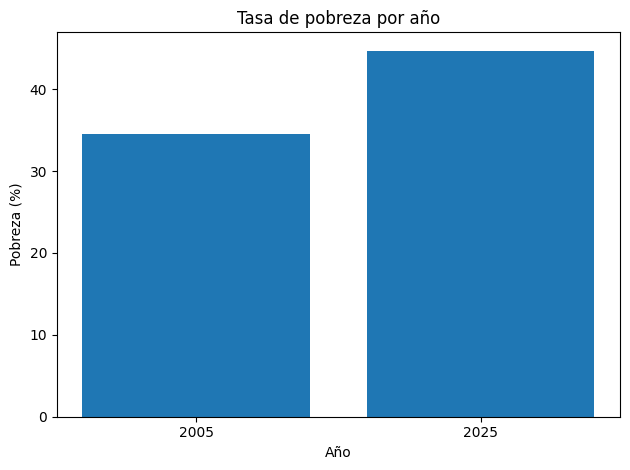

<Figure size 640x480 with 0 Axes>

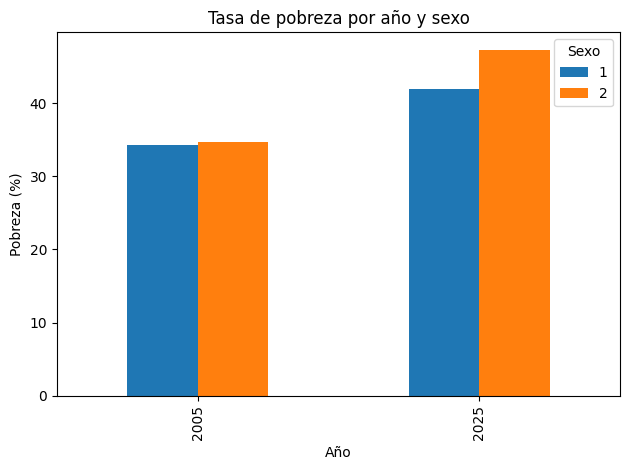

In [ ]:
# =========================
# PREGUNTA 9 – DESCRIPTIVOS Y GRÁFICOS DE "pobre"
# =========================


import matplotlib.pyplot as plt

# --- Helpers de promedio/suma ponderada ---
def tiene_pesos(df, col="PONDERA"):
    return col in df.columns

def media_ponderada(serie, pesos):
    if pesos is None:
        return serie.mean()
    return np.average(serie, weights=pesos)

def suma_ponderada(serie, pesos):
    if pesos is None:
        return serie.sum()
    return (serie * pesos).sum()


df = respondieron.copy()
if "AÑO" in df.columns:
    df["AÑO"] = df["AÑO"].astype(str)

usa_pesos = tiene_pesos(df, "PONDERA")

# =========================
# TABLA 1: Descriptivos por AÑO
# =========================
filas = []
for anio, g in df.groupby("AÑO"):
    w = g["PONDERA"] if usa_pesos else None
    n_obs = g.shape[0] if w is None else w.sum() 
    n_pobres = suma_ponderada(g["pobre"], w)
    tasa_pob = 100 * media_ponderada(g["pobre"], w)
    filas.append({"AÑO": anio, "n_obs": n_obs, "n_pobres": n_pobres, "tasa_pobreza_%": tasa_pob})

tabla_anio = pd.DataFrame(filas).sort_values("AÑO").reset_index(drop=True)
print("Descriptivos de pobreza por año:")
display(tabla_anio)

# =========================
# TABLA 2: Descriptivos por AÑO y SEXO
# =========================
if "CH04" in df.columns:
    filas2 = []
    for (anio, sexo), g in df.groupby(["AÑO", "CH04"]):
        w = g["PONDERA"] if usa_pesos else None
        n_obs = g.shape[0] if w is None else w.sum()
        n_pobres = suma_ponderada(g["pobre"], w)
        tasa_pob = 100 * media_ponderada(g["pobre"], w)
        filas2.append({"AÑO": anio, "CH04": sexo, "n_obs": n_obs, "n_pobres": n_pobres, "tasa_pobreza_%": tasa_pob})
    tabla_anio_sexo = pd.DataFrame(filas2).sort_values(["AÑO", "CH04"]).reset_index(drop=True)
    print("\nDescriptivos de pobreza por año y sexo:")
    display(tabla_anio_sexo)
else:
    tabla_anio_sexo = None
    print("\n(No se encontró columna CH04; se omite la tabla por sexo.)")

# =========================
# GRÁFICO 1: Tasa de pobreza por AÑO
# =========================
plt.figure()
plt.bar(tabla_anio["AÑO"].astype(str), tabla_anio["tasa_pobreza_%"])
plt.title("Tasa de pobreza por año")
plt.xlabel("Año")
plt.ylabel("Pobreza (%)")
plt.tight_layout()
plt.show()

# =========================
# GRÁFICO 2: Tasa de pobreza por AÑO y SEXO
# =========================
if tabla_anio_sexo is not None and not tabla_anio_sexo.empty:
    pivot = tabla_anio_sexo.pivot(index="AÑO", columns="CH04", values="tasa_pobreza_%").fillna(0)
    plt.figure()
    pivot.plot(kind="bar")
    plt.title("Tasa de pobreza por año y sexo")
    plt.xlabel("Año")
    plt.ylabel("Pobreza (%)")
    plt.legend(title="Sexo")
    plt.tight_layout()
    plt.show()
